In [1]:
# general
import warnings
from datasets import load_dataset
from Utils.Utilities import *
from Utils.Tests import *
from os.path import isfile

# ML
import pandas as pd

# visual
import matplotlib.pyplot as plt
import seaborn as sns

# # DL
import torch
from torch import nn
from transforms.Transform_Builder import Transform_Builder
from Utils.Model_Builder import Model_Builder
from Enums.ModelType import ModelType
from Enums.ModelPath import ModelPath
from Config import TrainParams

warnings.filterwarnings('ignore')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
SEED = 42

## Load the dataset

In [2]:
dataset = load_dataset("cats_vs_dogs", trust_remote_code=True, verification_mode='no_checks')
dataset = dataset['train']

In [3]:
splitted_dataset = dataset.train_test_split(test_size=0.05, shuffle=True, seed=SEED)
train_val_dataset = splitted_dataset['train'].train_test_split(test_size=0.05, shuffle=True, seed=SEED)

In [4]:
train = train_val_dataset['train']
val = train_val_dataset['test']
test = splitted_dataset['test']

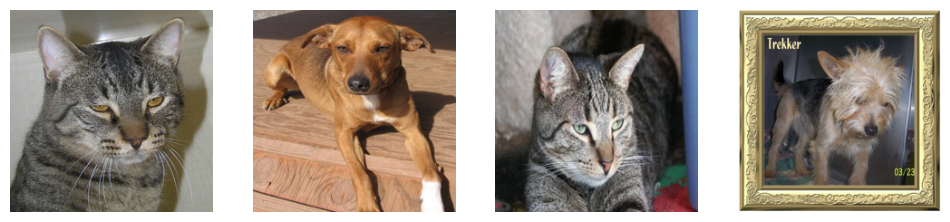

In [5]:
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    img = train[i]['image'].resize((224,224))
    axes[i].imshow(img)
    axes[i].axis('off')
plt.show()

## Loading baseline models

### 1. Pretrained Model

In [5]:
pretrained_optimizer_params = {"lr" : 5e-3, "momentum" : 0.9}
pretrained_params = TrainParams(5, torch.optim.SGD, pretrained_optimizer_params, False)
pretrained_dataloaders = Model_Builder.build_dataloaders(train,val,test, Transform_Builder.build(size=224))
pretrained_model = Model_Builder.build(ModelType.PRETRAINED, device, pretrained_params, pretrained_dataloaders, path=ModelPath.BASELINE_PRETRAINED.value)

### 2. Custom Model

In [6]:
# 19 mins train run without weights 
custom_optimizer_params = {"lr" : 1e-3}
custom_params = TrainParams(30, torch.optim.Adam, custom_optimizer_params, False)
custom_dataloaders = Model_Builder.build_dataloaders(train,val,test, Transform_Builder.build(size=100))
custom_model = Model_Builder.build(ModelType.CUSTOM, device, custom_params, custom_dataloaders, path=ModelPath.BASELINE_CUSTOM.value)

### 3. Vit Model

In [7]:
vit_model = Model_Builder.build(ModelType.VIT, device)
vit_dataloaders = Model_Builder.build_dataloaders(train,val,test, Transform_Builder.build(is_vit=True, processor=vit_model.processor))

## Evaluating Baseline models

In [8]:
# 15 sec run
results= {"Accuracy":[], "Model Type" : [ModelType.CUSTOM.name, ModelType.PRETRAINED.name, ModelType.VIT.name]}
baseline_models = [custom_model, pretrained_model, vit_model]
test_datasets = [custom_dataloaders['test'], pretrained_dataloaders['test'], vit_dataloaders['test']]

for model, test_set in zip(baseline_models,test_datasets):
    model.predict_data(test_set)
    results['Accuracy'].append(model.test_acc)

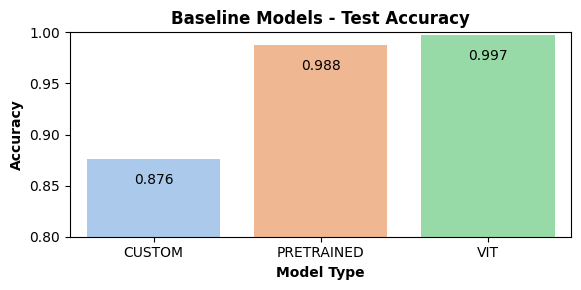

In [11]:
draw_bar_plot(data= pd.DataFrame(results), y='Accuracy', x='Model Type', title='Baseline Models - Test Accuracy', ylim=(0.8,1))

## Test - Accuarcy as a function of number of tiles:

In [12]:
tiles_num_options = [4,9,16,25,36]
models_params = {ModelType.CUSTOM.name : {"Model": custom_model, "size" : 100, "is_vit" : False, "processor" : None}, 
                 ModelType.PRETRAINED.name : {"Model": pretrained_model, "size" : 224, "is_vit" : False, "processor" : None},
                 ModelType.VIT.name : {"Model": vit_model,  "size" : 224, "is_vit" : True, "processor" : vit_model.processor}}

In [13]:
# 1.4 mins run
tile_num_test_result = run_tile_num_test(models_params, tiles_num_options, test)

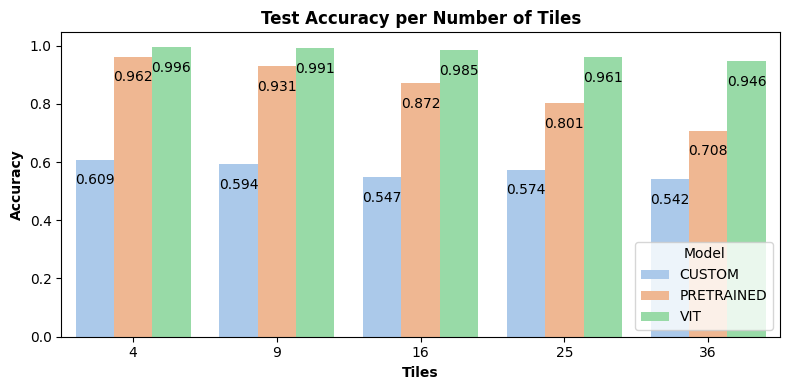

In [240]:
draw_bar_plot(data= pd.DataFrame(tile_num_test_result), y='Accuracy', x='Tiles', title='Test Accuracy per Number of Tiles', figsize=(8,4), hue="Model")

## Permutation Ranking

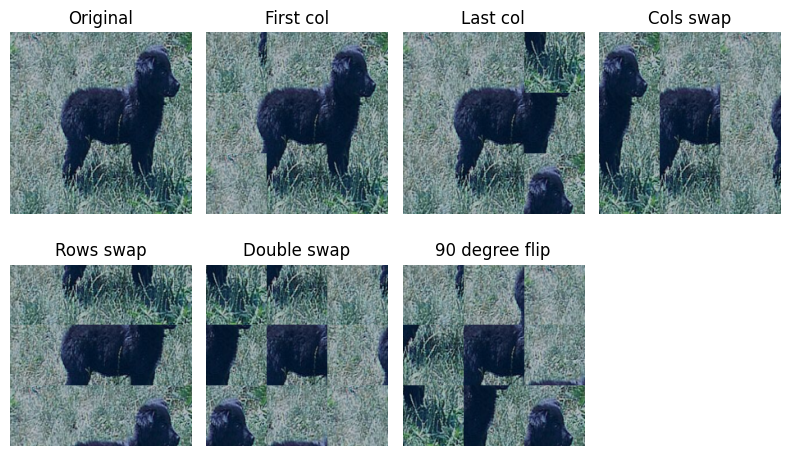

In [16]:
tiles_num = 9
permutation_dict = create_premutation(tiles_num)
permuted_test_set = test.with_transform(Transform_Builder.build(224, with_premute=True, tiles_num=tiles_num, permutations_set= list(permutation_dict.values())))
draw_images(permuted_test_set[0]['image'], permutation_dict.keys())

### Custom model

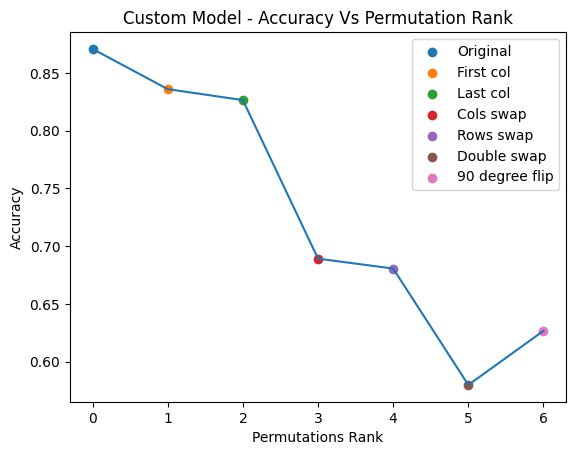

In [17]:
# 30 secs run
test_set = test.with_transform(Transform_Builder.build(100))
base_score = calculate_tiles_derivative(test_set[:]['image'])
custom_results = run_permutation_rank_test(model=custom_model, test=test, permutation_dict=permutation_dict, size=100, base_score=base_score)
draw_rank_test_results(custom_results, permutation_dict, "Custom Model")

### Pretrained Model

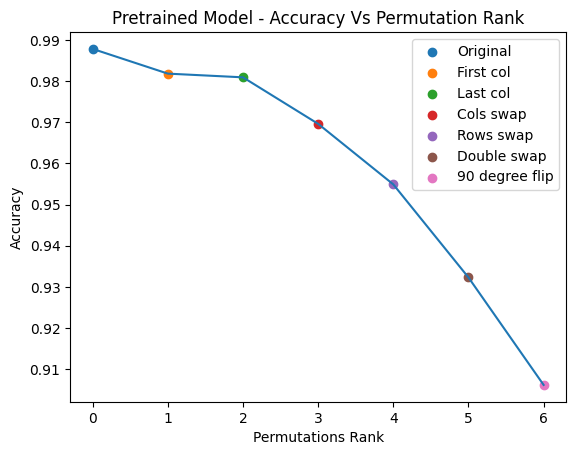

In [230]:
# 52 secs run
test_set = test.with_transform(Transform_Builder.build(224))
base_score = calculate_tiles_derivative(test_set[:]['image'])
pretrained_results = run_permutation_rank_test(model=pretrained_model, test=test, permutation_dict=permutation_dict, base_score=base_score, size=224)
draw_rank_test_results(pretrained_results, permutation_dict, 'Pretrained Model')

### Vit Model

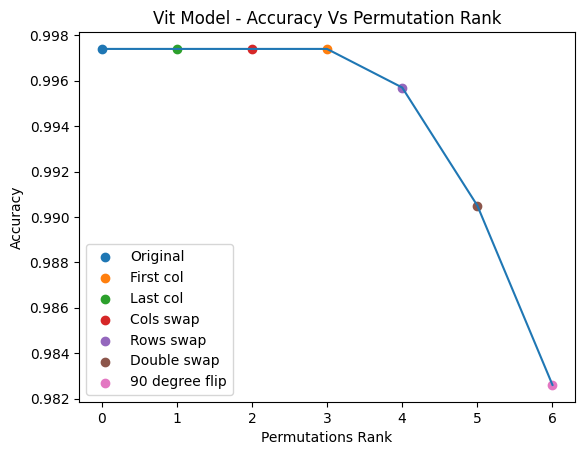

In [231]:
# 4 mins run
test_set = test.with_transform(Transform_Builder.build(is_vit=True, processor=vit_model.processor))
base_score = calculate_tiles_derivative(test_set[:]['image'])
Vit_results = run_permutation_rank_test(model=vit_model, test=test, permutation_dict=permutation_dict, base_score = base_score, is_vit=True, processor=vit_model.processor)
draw_rank_test_results(Vit_results, permutation_dict, 'Vit Model')

## Question 2 

### FineTune on specific permutation and check other permutations' accuracies 

### Custom Model

#### Finetune Custom model with 'Rows swap' permutation

In [184]:
custom_transform = Transform_Builder.build(size=100, with_premute=True, tiles_num=9, permutations_set=[permutation_dict['Rows swap']])
custom_dataloaders = Model_Builder.build_dataloaders(train,val,test, custom_transform)
custom_optimizer_params = {"lr" : 1e-3}
custom_params = TrainParams(20, torch.optim.Adam, custom_optimizer_params, False)
ft_custom_model = Model_Builder.build(ModelType.CUSTOM, device, custom_params, custom_dataloaders, path=ModelPath.PERMUTATION_FT_CUSTOM.value)

In [19]:
# 15 sec run
custom_permutation_results = run_accuracy_test(model=ft_custom_model, test=test, permutation_dict=permutation_dict, size=100)

In [99]:
custom_permutation_df = pd.DataFrame(custom_permutation_results)
custom_permutation_df['State'] = 'After train'
custom_rank_test_result_df = pd.DataFrame(data=custom_results['Accuracy'], columns=['Accuracy'], index= custom_permutation_df.Permutation).reset_index()
custom_rank_test_result_df['State'] = 'Before train'
custom_model_premutation_df = pd.concat([custom_permutation_df, custom_rank_test_result_df])
custom_model_premutation_df['Model'] = 'Original'

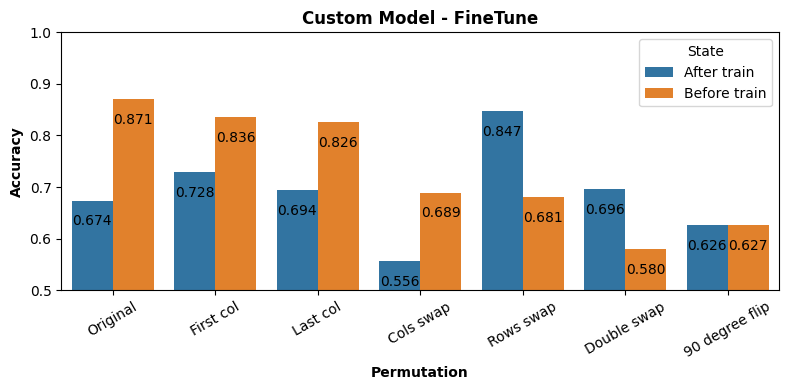

In [224]:
draw_bar_plot(data=custom_model_premutation_df,  x='Permutation', y='Accuracy', \
              hue='State', title='Custom Model - FineTune', figsize=(8,4), ylim=(0.5,1), rotation=30, palette=None, value_verbose=True, legend_loc='upper right')

#### Improving Custom model - Using Improved model:

##### The Improved model includes BatchNorm, MaxPool and Dropout layers in its final sequential convolutional layer

In [40]:
# 17 mins train run without weights 
custom_dataloaders = Model_Builder.build_dataloaders(train,val,test, Transform_Builder.build(size=100))
custom_optimizer_params = {"lr" : 1e-3}
custom_params = TrainParams(30, torch.optim.Adam, custom_optimizer_params, False)
improved_custom_model = Model_Builder.build(ModelType.IMPROVED_CUSTOM, device, custom_params, custom_dataloaders, path=ModelPath.BASELINE_IMPROVED_CUSTOM.value)

In [41]:
# 15 sec run
improved_custom_results = run_accuracy_test(model=improved_custom_model, test=test, permutation_dict=permutation_dict, size=100)

In [43]:
improved_custom_df = pd.DataFrame(improved_custom_results)
improved_custom_df['Model'] = 'Improved Model'
custom_df = pd.DataFrame(data=custom_results['Accuracy'], columns=['Accuracy'], index= improved_custom_df.Permutation).reset_index()
custom_df['Model'] = 'Original Model'

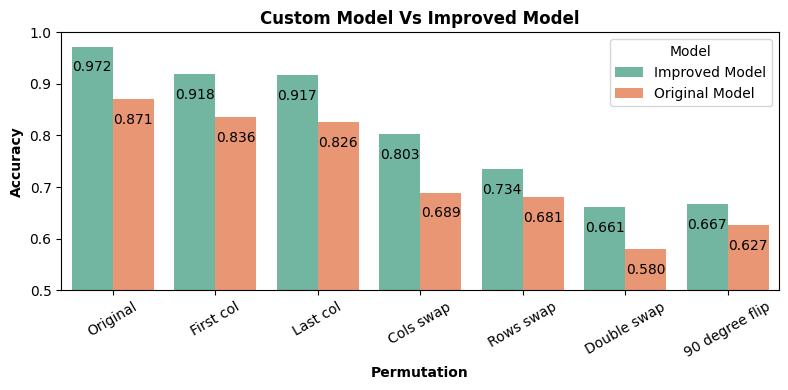

In [219]:
draw_bar_plot(data=pd.concat([improved_custom_df, custom_df]),  x='Permutation', y='Accuracy', \
              hue='Model', title='Custom Model Vs Improved Model', figsize=(8,4), ylim=(0.5,1), rotation=30, value_verbose=True, palette='Set2', legend_loc='upper right')

#### Finetune Improved model with 'Rows swap' permutation

In [56]:
improved_custom_transform = Transform_Builder.build(size=100, with_premute=True, tiles_num=9, permutations_set=[permutation_dict['Rows swap']])
improved_custom_dataloaders = Model_Builder.build_dataloaders(train,val,test, improved_custom_transform)
improved_custom_optimizer_params = {"lr" : 1e-3}
improved_custom_params = TrainParams(20, torch.optim.Adam, improved_custom_optimizer_params, False)
ft_improved_custom_model = Model_Builder.build(ModelType.IMPROVED_CUSTOM, device, improved_custom_params, improved_custom_dataloaders, path=ModelPath.PERMUTATION_FT_IMPROVED_CUSTOM.value)

In [57]:
# 15 sec run
ft_improved_custom_results = run_accuracy_test(model=ft_improved_custom_model, test=test, permutation_dict=permutation_dict, size=100)

In [208]:
ft_improved_custom_accuracy_test_result_df = pd.DataFrame(ft_improved_custom_results)
ft_improved_custom_accuracy_test_result_df['State'] = 'After train'
improved_custom_accuracy_test_result_df = pd.DataFrame(data=pd.DataFrame(improved_custom_results))
improved_custom_accuracy_test_result_df['State'] = 'Before train'
improved_model_premutation_df = pd.concat([ft_improved_custom_accuracy_test_result_df, improved_custom_accuracy_test_result_df])
improved_model_premutation_df['Model'] = 'Improved'

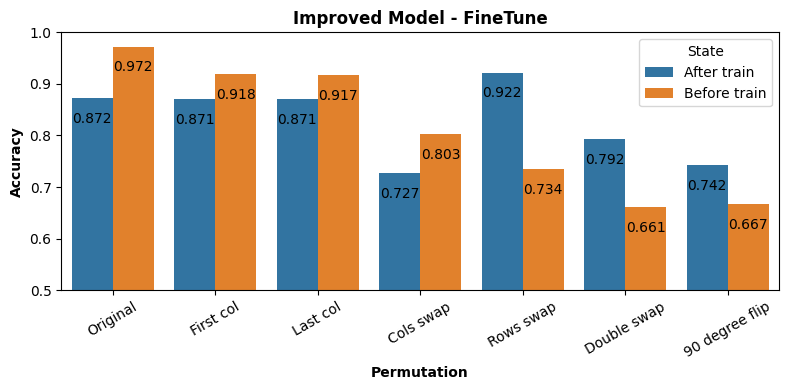

In [223]:
draw_bar_plot(data=improved_model_premutation_df,  x='Permutation', y='Accuracy', \
              hue='State', title='Improved Model - FineTune', figsize=(8,4), ylim=(0.5,1), rotation=30, palette=None, value_verbose=True, legend_loc='upper right')

#### Further Improving Custom model - 
#### by finetune the Improved model on several permutation instead of specific one:

In [101]:
# FT better custom model on several permutations
if isfile(ModelPath.SEVERAL_PERMUTATION_FT_IMPROVED_CUSTOM.value):
    improved_custom_model = Model_Builder.build(ModelType.IMPROVED_CUSTOM, device, custom_params, custom_dataloaders, path=ModelPath.SEVERAL_PERMUTATION_FT_IMPROVED_CUSTOM.value)
else:
    permutations = ["Rows swap", "Cols swap", "First col", "Last col" ]
    for premutation in permutations:

        custom_transform = Transform_Builder.build(size=100, with_premute=True, tiles_num=9, permutations_set=[permutation_dict[premutation]])
        custom_dataloaders = Model_Builder.build_dataloaders(train,val,test, custom_transform)

        custom_optimizer_params = {"lr" : 1e-3}
        custom_params = TrainParams(5, torch.optim.Adam, custom_optimizer_params, False)
        model_optimizer = custom_params.optimizer(improved_custom_model.parameters(), **custom_params.optimizer_params)
        criterion = nn.CrossEntropyLoss()
        improved_custom_model.start_train(criterion, model_optimizer, dataloaders=custom_dataloaders, num_epochs=custom_params.num_epochs, verbose=custom_params.verbose)


In [102]:
several_ft_improved_custom_results = run_accuracy_test(model=improved_custom_model, test=test, permutation_dict=permutation_dict, size=100)

In [185]:
several_ft_improved_custom_permutation_df = pd.DataFrame(several_ft_improved_custom_results)
several_ft_improved_custom_permutation_df['State'] = 'After train'
several_imported_model_premutation_df= pd.concat([several_ft_improved_custom_permutation_df, improved_custom_accuracy_test_result_df])
several_imported_model_premutation_df['Model'] = 'Improved-Several'

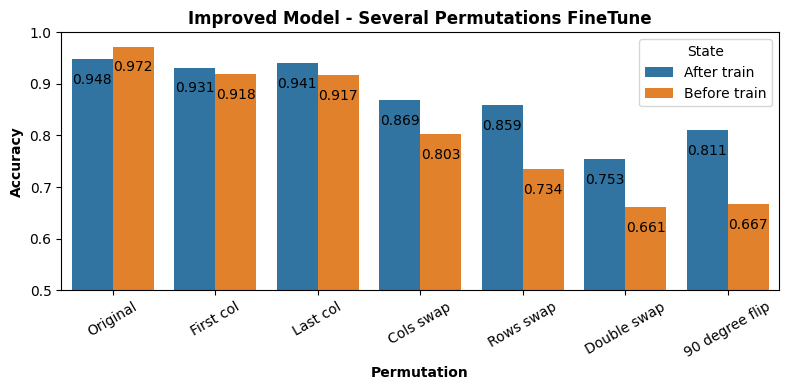

In [222]:
draw_bar_plot(data=several_imported_model_premutation_df,  x='Permutation', y='Accuracy', \
              hue='State', title='Improved Model - Several Permutations FineTune', figsize=(8,4), ylim=(0.5,1), rotation=30, palette=None, value_verbose=True, legend_loc='upper right')

In [213]:
permutation_test_final_df= pd.concat([several_imported_model_premutation_df[several_imported_model_premutation_df.State == 'After train'], 
improved_model_premutation_df[improved_model_premutation_df.State == 'Before train'],
custom_model_premutation_df.loc[custom_model_premutation_df.State == 'Before train']])

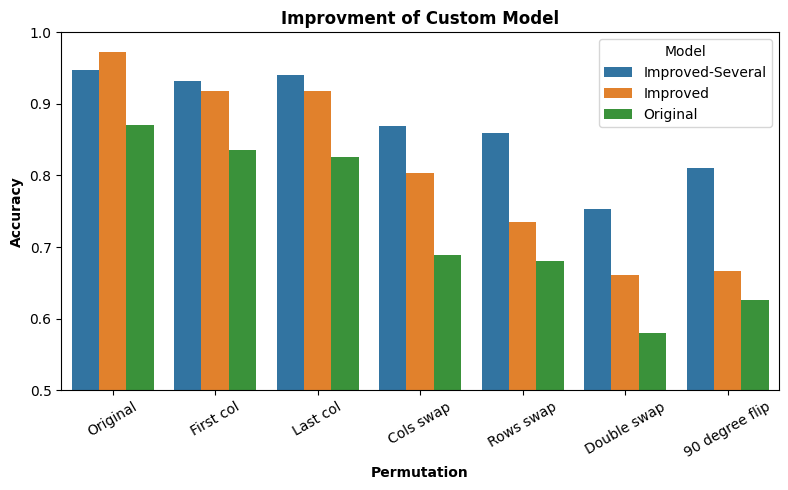

In [226]:
draw_bar_plot(data=permutation_test_final_df,  x='Permutation', y='Accuracy', \
              hue='Model', title='Improvment of Custom Model', figsize=(8,5), ylim=(0.5,1), rotation=30, palette=None, value_verbose=False, legend_loc='upper right')

### Pretrained Model

In [227]:
pretrained_transform = Transform_Builder.build(size=224, with_premute=True, tiles_num=9, permutations_set=[permutation_dict['Rows swap']])
pretrained_dataloaders = Model_Builder.build_dataloaders(train,val,test, pretrained_transform)
pretrained_optimizer_params = {"lr" : 5e-3, "momentum" : 0.9}
pretrained_params = TrainParams(5, torch.optim.SGD, pretrained_optimizer_params, False)
ft_pretrained_model = Model_Builder.build(ModelType.PRETRAINED, device, pretrained_params, pretrained_dataloaders, path=ModelPath.PERMUTATION_FT_PRETRAINED.value)

In [228]:
# 25 secs run
pretrained_permutation_results = run_accuracy_test(model=ft_pretrained_model, test=test, permutation_dict=permutation_dict, size=224)

In [232]:
pretrained_permutation_df = pd.DataFrame(pretrained_permutation_results)
pretrained_permutation_df['State'] = 'After train'
pretrained_rank_test_result_df = pd.DataFrame(data=pretrained_results['Accuracy'], columns=['Accuracy'], index= pretrained_permutation_df.Permutation).reset_index()
pretrained_rank_test_result_df['State'] = 'Before train'

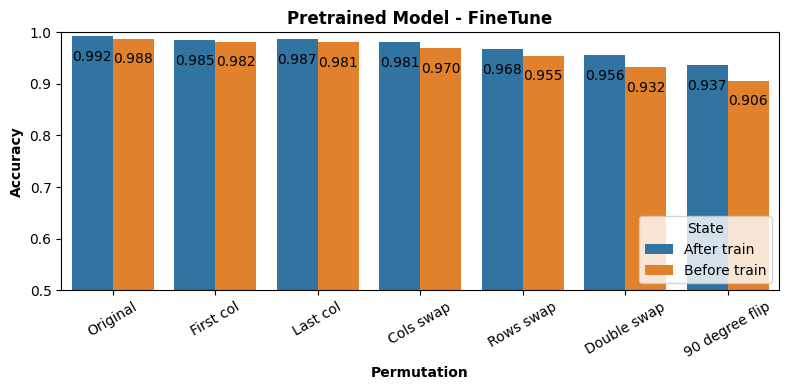

In [242]:
draw_bar_plot(data=pd.concat([pretrained_permutation_df, pretrained_rank_test_result_df]),  x='Permutation', y='Accuracy', \
              hue='State', title='Pretrained Model - FineTune', figsize=(8,4), ylim=(0.5,1), rotation=30, palette=None, value_verbose=True, legend_loc='lower right')

### Vit Model

In [235]:
vit_transform = Transform_Builder.build(with_premute=True, tiles_num=9, permutations_set=[permutation_dict['Rows swap']], is_vit=True, processor=vit_model.processor)
vit_dataloaders = Model_Builder.build_dataloaders(train,val,test, vit_transform)
optimizer_params = {"lr" : 2e-4, "betas" :(0.9,0.999), "eps": 1e-08}
vit_params = TrainParams(5, torch.optim.Adam, optimizer_params, False)
ft_vit_model = Model_Builder.build(ModelType.VIT, device, vit_params, vit_dataloaders, path=ModelPath.PERMUTATION_FT_VIT.value)

In [236]:
# 2 mins run
vit_permutation_results = run_accuracy_test(model=ft_vit_model, test=test, permutation_dict=permutation_dict, is_vit=True, processor=ft_vit_model.processor, size=224)

In [237]:
vit_permutation_df = pd.DataFrame(vit_permutation_results)
vit_permutation_df['State'] = 'After train'
vit_rank_test_result_df = pd.DataFrame(data=Vit_results['Accuracy'], columns=['Accuracy'], index= vit_permutation_df.Permutation).reset_index()
vit_rank_test_result_df['State'] = 'Before train'

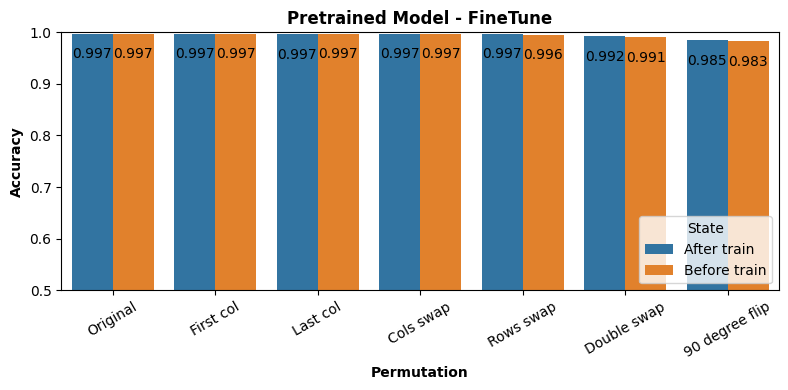

In [241]:
draw_bar_plot(data=pd.concat([vit_permutation_df, vit_rank_test_result_df]),  x='Permutation', y='Accuracy', \
              hue='State', title='Pretrained Model - FineTune', figsize=(8,4), ylim=(0.5,1), rotation=30, palette=None, value_verbose=True, legend_loc='lower right')